# infos

In [1]:
# Modèle basé sur les 10 espèces représentées


# Vérifier que les chemins soient correct avant toutes opérations
chemin_images = '../../images/'
chemin_csv = '../data/top10.csv'

# Définition du DataFrame echantillon (utile pour tests modèles car entrainements très rapides)
pourcentage_echantillon = 0.1 # Si 0.1 : 10% du contenu

# Dimensions des images
img_dim = (224,224)
img_shape = (224,224,3)

##### A faire sur le notebook :

- S'assurer que la data augmentation lisse le nb d'images par classe (modifier dans les fonctions) <-- Fait  mais à controler
- Ajouter exportation img sur def augment_img(image_path, label):
- Configurer Tensorboard (ajouter des fonctionnalités)

# Google Colab

Si le notebook tourne sur colab, charger les fichiers images (format zip) et dezipper en suivant les cellules qui suivent :

In [ ]:
# Importer les images en format .zip
from google.colab import files
files.upload()

In [2]:
# Monter le Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Dezipper le fichier
!unzip '/content/drive/MyDrive/SAS/images.zip' -d '/images'

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: /images/images/675184.jpg  
  inflating: /images/images/675185.jpg  
  inflating: /images/images/675186.jpg  
  inflating: /images/images/675187.jpg  
  inflating: /images/images/675188.jpg  
  inflating: /images/images/675257.jpg  
  inflating: /images/images/675258.jpg  
  inflating: /images/images/675262.jpg  
  inflating: /images/images/675266.jpg  
  inflating: /images/images/675269.jpg  
  inflating: /images/images/675270.jpg  
  inflating: /images/images/675272.jpg  
  inflating: /images/images/675277.jpg  
  inflating: /images/images/675279.jpg  
  inflating: /images/images/675281.jpg  
  inflating: /images/images/675294.jpg  
  inflating: /images/images/675295.jpg  
  inflating: /images/images/675296.jpg  
  inflating: /images/images/675348.jpg  
  inflating: /images/images/675349.jpg  
  inflating: /images/images/675492.jpg  
  inflating: /images/images/675493.jpg  
  inflating: /images

In [4]:
# Remplacer les chemins en corrélation avec les dossiers colab
chemin_images = '/images/images/'
chemin_csv = '/content/drive/MyDrive/SAS/Jul23_bds_champignons/data/top10.csv'

# Librairies à charger

In [2]:
# Librairies utilisées par les fonctions
import pandas as pd
import os
from tensorflow.keras.applications.efficientnet import preprocess_input


# Librairies utilisées pour les callbacks
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint
from timeit import default_timer as timer
from tensorflow.keras.callbacks import TerminateOnNaN


# Librairies utilisées pour créer les pipelines et le modèle
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers, models


# Librairies utilisées pour la création des jeux d'entrainement, de test et de validation
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from collections import Counter


# Librairies utilisées pour l'évaluation du modèle une fois entrainé
import matplotlib.pyplot as plt
%matplotlib inline


# Fonctions

In [3]:
def import_df(chemin_images, chemin_csv, pourcentage_echantillon):
    '''Importe le fichier csv et construit 2 df :
        - Le DF basé sur le CSV original
        - Un DF echantillon comportant 10% de données aléatoires du DF original

        '''


    # import du df
    df = pd.read_csv(chemin_csv, low_memory=False)
    df['image_url'] = df['image_url'].str.replace('.../images/', chemin_images)
    print(f"Nombre d'images chargées pour df: {df.shape[0]}")
    print(f"Nb especes dans df: {df['label'].nunique()}")


    # Contruction de l'echantillon
    L = len(df)
    L_ech = int(pourcentage_echantillon * L)
    df_ech = df.sample(n=L_ech, random_state=10)
    df_ech.reset_index(inplace=True, drop=True)
    print(f"Nombre d'images chargées pour df_ech: {df_ech.shape[0]}")
    print(f"Nb especes dans df_ech: {df_ech['label'].nunique()}")




    return df, df_ech

In [4]:
def augment_img(image_path, label):

    '''Modifie les images aléatoirement dans le dataset qui sera soumis au modèle, oversample les classes sous représentées.
       image_path : chemin des images (variable définie en début de notebook),
       label : Variable contenant les classes,
       '''

    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, img_dim)         # Rappel : img_dim est définie en début de Notebook
    img = preprocess_input(img)

    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_flip_up_down(img)
    img = tf.image.random_brightness(img, max_delta=0.2)
    img = tf.image.random_contrast(img, lower=0.8, upper=1.2)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = (img - tf.math.reduce_min(img)) / (tf.math.reduce_max(img) - tf.math.reduce_min(img))

# Exporter l'img dans le dossier ../../images sous un nom commençant par 900000.jpg

    return img, label

In [5]:
def create_tf_dataset(image_path, labels, batch_size, oversample_cls = None):
    '''
    Créé un dataset Tensorflow selon les paramètres précisés. La fonction oversample les classes sous représentées
    image_path : chemin relatif de la variable contenant les images
    labels : variable contenant les labels
    batch_size : taille des batchs
    oversample_cls : Liste contenant les classes à oversampler. Si non précisé, l'oversample sera ignoré
    '''

    image_path = image_path.tolist()  # Convertir les chemins d'images en liste
    labels = labels.tolist()          # Convertir les labels en liste


 # Oversample des classes
    if oversample_cls:
    # Compter le nombre d'exemples par classe
        class_counts = Counter(labels)

    # Calculer le nombre d'exemples à ajouter pour chaque classe à oversampler
        max_count = max(class_counts.values())
        facteurs_oversample = {cls: max_count / count for cls, count in class_counts.items() if cls in oversample_cls}

    # Répéter les exemples des classes à oversampler pour atteindre le nombre maximum
        oversampled_image_paths = []
        oversampled_labels = []
        for img_path, label in zip(image_path, labels):
            facteurs_oversample = facteurs_oversample.get(label, 1.0)
            nb_copies = int(facteurs_oversample)
            for _ in range(nb_copies):
                oversampled_image_paths.append(img_path)
                oversampled_labels.append(label)

        image_path = oversampled_image_paths
        labels = oversampled_labels



    # Construction du Dataset
    dataset = tf.data.Dataset.from_tensor_slices((image_path, labels))
    dataset = dataset.map(augment_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.shuffle(buffer_size=len(image_path))
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset

In [6]:
def controle_presence_fichiers(df, chemin_images):

    ''' Controle que les fichiers images soient bien présents sur le disque.'''

    image_directory = chemin_images
    missing_files = []

# Parcourir chaque ligne du DataFrame
    for index, row in df.iterrows():
        image_path = os.path.join(image_directory, row['image_lien'])

        if not os.path.exists(image_path):
            missing_files.append(image_path)

    # Afficher les fichiers non trouvés
    if missing_files:
        print("\nFichiers non trouvés :")
        for file_path in missing_files:
            print(file_path)
    else:
        print("\nTous les fichiers sont présents.")

# Callbacks

### Tensorboard

In [18]:
%load_ext tensorboard
log_dir = '../tensor_board_logs'
tensorboard = callbacks.TensorBoard(log_dir = log_dir)

### EarlyStopping

In [19]:
early_stopping = EarlyStopping(monitor = 'accuracy',
                               min_delta = 0.01,
                               patience = 5,
                               verbose = 1,
                               mode = 'auto',
                               restore_best_weights = True)

### Reduce LearningRate

In [20]:
reduceLR = ReduceLROnPlateau(monitor = 'val_loss',
                             min_delta = 0.01,
                             patience = 5,
                             factor = 0.15,
                             cooldown = 3,
                             verbose = 1)

### Checkpoint

In [21]:
checkpoint = ModelCheckpoint(filepath='../model/checkpoint_model', monitor='val_accuracy', save_best_only=True, verbose=1)

### Timer

In [22]:
class TimingCallback(Callback):
    def __init__(self):
        super().__init__()
        self.logs = []

    def on_epoch_begin(self, epoch, logs=None):
        self.starttime = timer()

    def on_epoch_end(self, epoch, logs=None):
        endtime = timer()
        elapsed_time = endtime - self.starttime
        self.logs.append(elapsed_time)
        print(f"Epoch {epoch + 1} took {elapsed_time:.2f} seconds")

time_callback = TimingCallback()

### Terminate on NaN

In [23]:
TON = TerminateOnNaN()

# Construction modèle

### Import du modèle pré-entrainé

In [16]:
efficientNetv2 = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b0/classification/2"
pre_trained_model = hub.KerasLayer(efficientNetv2, input_shape=(224, 224, 3), trainable=False)


### Couches denses et construction

In [17]:
# Créer le modèle CNN
model = models.Sequential()
model.add(pre_trained_model)

# Couches entièrement connectées
#model.add(layers.Flatten())
#model.add(layers.Dense(128, activation='relu'))
#model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation='softmax'))  # 10 classes de sortie

### Compilation du modèle

In [18]:
# Compiler le modèle
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [19]:
# Afficher un résumé du modèle
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1000)              7200312   
                                                                 
 dense (Dense)               (None, 10)                10010     
                                                                 
Total params: 7210322 (27.51 MB)
Trainable params: 10010 (39.10 KB)
Non-trainable params: 7200312 (27.47 MB)
_________________________________________________________________


# Pipeline Dataset

### Import des DataFrames

In [7]:
# Rappel : Utiliser df_ech pour les tests (entrainement rapide du modèle mais accuracy faible)
df, df_ech = import_df(chemin_images, chemin_csv, pourcentage_echantillon)

Nombre d'images chargées pour df: 60481
Nb especes dans df: 10
Nombre d'images chargées pour df_ech: 6048
Nb especes dans df_ech: 10


C:\Users\guill\AppData\Local\Temp\ipykernel_17924\1307872526.py:11: FutureWarning: The default value of regex will change from True to False in a future version.
  df['image_url'] = df['image_url'].str.replace('.../images/', chemin_images)


In [8]:
# Préciser sur quelles données travailler (df_ech est un echantillon permettant de réduire le temps d'entrainement pour effectuer des tests)
# Commenter/Decommenter la ligne souhaitée
#donnees_training = df_ech
donnees_training = df

In [9]:
# Représentation des classes
print('Facteurs d\'oversampling des classes : \n',
      'Agaricales : x1 \n',
      'Agaricus: x2.5 \n',
      'Amanita : x2 \n',
      'Cortinarius: x1.5 \n',
      'Entoloma : x2.5 \n',
      'Inocybe: x2 \n',
      'Mycena : x2 \n',
      'Popyporales: x1.8 \n',
      'Psathyrella : x2 \n',
      'Russula: x1.5 \n')

donnees_training.groupby('label').count()

Facteurs d'oversampling des classes : 
 Agaricales : x1 
 Agaricus: x2.5 
 Amanita : x2 
 Cortinarius: x1.5 
 Entoloma : x2.5 
 Inocybe: x2 
 Mycena : x2 
 Popyporales: x1.8 
 Psathyrella : x2 
 Russula: x1.5 



,image_lien,image_url
label,,
Agaricales,11126,11126
Agaricus,4545,4545
Amanita,4887,4887
Cortinarius,6970,6970
Entoloma,3918,3918
Inocybe,4439,4439
Mycena,4928,4928
Polyporales,6595,6595
Psathyrella,5124,5124


In [10]:
# Controle de la présence des fichiers images
controle_presence_fichiers(donnees_training, chemin_images)

# On supprime ensuite la colonne image_lien qui ne sert qu'à controler la présence des fichiers.
donnees_training.drop('image_lien', axis=1, inplace=True)


Tous les fichiers sont présents.


In [11]:
# Définir les classes à oversampler :
oversample_cls = ['Agaricus', 'Amanita', 'Cortinarius', 'Entoloma', 'Inocybe', 'Mycena', 'Polyporales', 'Psathyrella', 'Russula']

### Construction des jeux de données (train, test et validation)

In [12]:
data = donnees_training.drop('label', axis=1)
target = donnees_training['label']

s = LabelEncoder()
target = s.fit_transform(target) # Encodage de la variable 'label'

# On construit le jeu d'entrainnement. X_temp et y_temps servent pour la construction des jeux de test et validation
X_train, X_temp, y_train, y_temp = train_test_split(data, target, test_size=0.25, random_state=10)

# On split les temp en 50% pour test, 50% pour validation
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=10)

### Construction des dataset Tensorflow

In [13]:
batch_size = 64
# Les datasets sont créés à partir de la fonction create_tf_dataset définie dans la partie 'Fonctions'
ds_train= create_tf_dataset(X_train.image_url, y_train, batch_size)
ds_test = create_tf_dataset(X_test.image_url, y_test, batch_size)
ds_val = create_tf_dataset(X_val.image_url, y_val, batch_size)

# Entrainement du modèle

### Methode .fit

In [29]:
history = model.fit(ds_train,
                    validation_data = ds_val,
                    epochs=50,
                    callbacks = [tensorboard, early_stopping, reduceLR, checkpoint, time_callback, TON],
                    verbose=True)

Epoch 1/50
  5/755 [..............................] - ETA: 21s - loss: 1.1803 - accuracy: 0.5906

754/755 [============================>.] - ETA: 0s - loss: 1.2857 - accuracy: 0.5621
Epoch 1: val_accuracy did not improve from 0.57233
Epoch 1 took 35.01 seconds
755/755 [==============================] - 35s 33ms/step - loss: 1.2858 - accuracy: 0.5621 - val_loss: 1.3060 - val_accuracy: 0.5580 - lr: 0.0010
Epoch 2/50
754/755 [============================>.] - ETA: 0s - loss: 1.2376 - accuracy: 0.5711
Epoch 2: val_accuracy did not improve from 0.57233
Epoch 2 took 34.11 seconds
755/755 [==============================] - 34s 32ms/step - loss: 1.2376 - accuracy: 0.5711 - val_loss: 1.2769 - val_accuracy: 0.5694 - lr: 0.0010
Epoch 3/50
753/755 [============================>.] - ETA: 0s - loss: 1.2181 - accuracy: 0.5821
Epoch 3: val_accuracy did not improve from 0.57233
Epoch 3 took 34.23 seconds
755/755 [==============================] - 34s 33ms/step - loss: 1.2181 - accuracy: 0.5820 - val_loss: 1.2703 - val_accuracy: 0.5671 - lr: 0.0010
Epoch 4/50
753/755 [============================>.]

### [En cas de crash durant l'entrainement]

In [27]:
# Cellule reservée au chargement du modèle checkpoint pour relancer l'entrainnement si le kernel crash
# /!\ Ne pas utiliser ces cellules si l'entrainement s'est réalisé en entier /!\
from tensorflow.keras.models import load_model
loaded_model = load_model('../model/checkpoint_model')
epoch_crash = 11            # Préciser le dernier epoch interrompu
nb_epochs_a_realiser = 2   # Nombre total d'epochs souhaité à partir de la reprise

In [28]:
# Reprise de l'entrainement
history = loaded_model.fit(ds_train,
                           validation_data=ds_val,
                           initial_epoch=epoch_crash,
                           epochs=nb_epochs_a_realiser,
                           callbacks=[tensorboard, early_stopping, reduceLR, checkpoint, time_callback, TON],
                           verbose=True)

# Evaluation du modèle

##### Prediction

In [ ]:
y_pred_train = model.predict(ds_train)
y_pred_test = model.predict(ds_test)
y_pred_val = model.predict(ds_val)
# probabilités
probs = model.predict_proba(ds_test)
y_probs = np.where(probs[:,1]>0.5,1,0)

##### Accuracy sur test

In [ ]:
test_loss, test_accuracy = model.evaluate(ds_test)
print("Test accuracy:", test_accuracy)

##### Courbes accuracy & val_accuracy

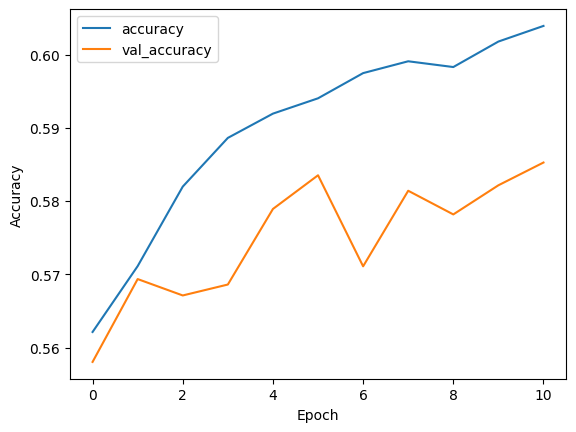

In [31]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

##### Rapport de classification

In [ ]:
from imblearn.metrics import classification_report_imbalanced
classification_report_imbalanced(y_test, y_pred_test)

##### Matrice de confusion

In [ ]:

pd.crosstab(y_test, y_pred_test, rownames = ['Classe réelle'], colnames = ['Classe prédite'])

In [ ]:
from sklearn.metrics import confusion_matrix
matrice = confusion_matrix(y_test, y_pred_test)
classes = range(0,10)

plt.figure()

plt.imshow(matrice, interpolation='nearest',cmap='Blues')
plt.title("Matrice de confusion")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

for i, j in itertools.product(range(matrice.shape[0]), range(matrice.shape[1])):
    plt.text(j, i, matrice[i, j],
             horizontalalignment = "center",
             color = "white" if matrice[i, j] > (matrice.max() / 2) else "black")

plt.ylabel('Vrais labels')
plt.xlabel('Labels prédits')
plt.show()

# Sauvegarde du modèle

In [32]:
# Changer le nom du modèle si il s'agit d'un nouvel entrainement

# Save en dur
#nom_modele = '../model/gpot_v01_full'

# Save sur GDrive
nom_modele =  '/content/drive/MyDrive/SAS/model/gpot_v01_full'

In [33]:
model.save(nom_modele)